In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [17]:
def gnerate_vel_and_ac(exp, var, T, V0, numb):
    arr = np.zeros(numb)
    a = np.random.normal(exp, var ** 0.5, numb)
    arr[0] = V0
    for i in range(1, len(arr)):
        arr[i] = arr[i - 1] + a[i - 1] * T
    return arr, a
def generate_x(T, X0, a, v):
    arr = np.zeros(len(a))
    arr[0] = X0
    for i in range(1, len(a)):
        arr[i] = arr[i - 1] + v[i - 1] * T + a[i - 1] * (T ** 2) / 2
    return arr

def kalman_filt(z, X0, P0, F, Q, R, H):
    Xii = np.zeros([200, 2])
    Xiin1 = np.zeros([200, 2])
    Piin1 = np.zeros([200, 2 , 2])
    Pii = np.zeros([200, 2 , 2])
    K = np.zeros([200, 2])
    Xii[0] = X0
    Xiin1[0] = X0
    Pii[0] = P0
    Piin1[0] = P0
    for i in range(1, len(X)):
        Xiin1[i] = np.dot(F, Xii[i - 1].reshape(2, 1)).reshape(1, 2)
        Piin1[i] = np.dot(np.dot(F, Pii[i - 1]), F.transpose()) + Q

        if np.isnan(z[i]):
            Xii[i] = Xiin1[i]
            Pii[i] = Piin1[i]
        else:
            K[i] = (Piin1[i].dot(H.reshape(2, 1))).dot((((H.reshape(1,2)).dot(Piin1[i])).dot(H.reshape(2, 1)) + R) ** (-1)).reshape(1, 2)
            Xii[i] = Xiin1[i] + K[i] * (z[i] - np.dot(H, Xiin1[i]))
            Pii[i] = (np.identity(2) - (K[i].reshape(2,1)).dot(H.reshape(1,2))).dot(Piin1[i])
        
    return Xii, Pii, Piin1, K
        
def extrapol(x, m, F):
    arr = np.array(x)
    F_pow = np.linalg.matrix_power(F, m - 1)
    for i in range(len(x) - m + 1):
        arr[i + m - 1] = F_pow.dot(x[i])
    return arr

def backward_smooth(Xii, F, Pii, Piin1):
    x = np.array(Xii)
    Pn = np.array(Pii)
    A = np.zeros([200, 2, 2])
    for i in range(len(x) - 2, -1, -1):
        A[i] = (Pii[i].dot(F.transpose())).dot(np.linalg.inv(Piin1[i]))
        x[i] = Xii[i] + A[i].dot(x[i + 1] - F.dot(Xii[i]))
        Pn[i] = Pii[i] + (A[i].dot(Pn[i + 1] - Piin1[i])).dot(A[i].transpose())
    return x, Pn

In [18]:
x0 = 5
v0 = 1
T = 1
sigmaa_2 = 0.2 ** 2
numb = 200
v,a = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
x = generate_x(T, x0, a, v)
sigmaeta_2 = 20 ** 2
eta = np.random.normal(0, sigmaeta_2 ** 0.5, 200)
F = np.array([[1, T], [0, 1]])
G = np.array([T ** 2 / 2, T])
H = np.array([1, 0])
z = np.zeros(200)
X = np.zeros([200, 2])
X[0] = np.array([x[0], v[0]])
g = np.random.uniform(0, 1, 200)
for i in range(1, len(X)):
    X[i] = np.dot(F, X[i - 1]) + np.dot(G, a[i - 1])
for i in range(len(x)):
    if g[i] <= 0.3:
        z[i] = np.NaN
    else:
        z[i] = np.dot(H, X[i]) + eta[i]
Q = np.dot(np.dot(G, G.transpose()), sigmaa_2)
R = sigmaeta_2
X0 = np.array([5, 1])
P0 = np.array([[1000, 0], [0, 1000]])

In [19]:
X_filt, Pii, Piin1, K = kalman_filt(z, X0, P0, F, Q, R, H)

/var/folders/9y/cbn__xb93h3710lq08dsvk9r0000gn/T/ipykernel_60079/4096187482.py:33: RuntimeWarning: invalid value encountered in reciprocal
  K[i] = (Piin1[i].dot(H.reshape(2, 1))).dot((((H.reshape(1,2)).dot(Piin1[i])).dot(H.reshape(2, 1)) + R) ** (-1)).reshape(1, 2)


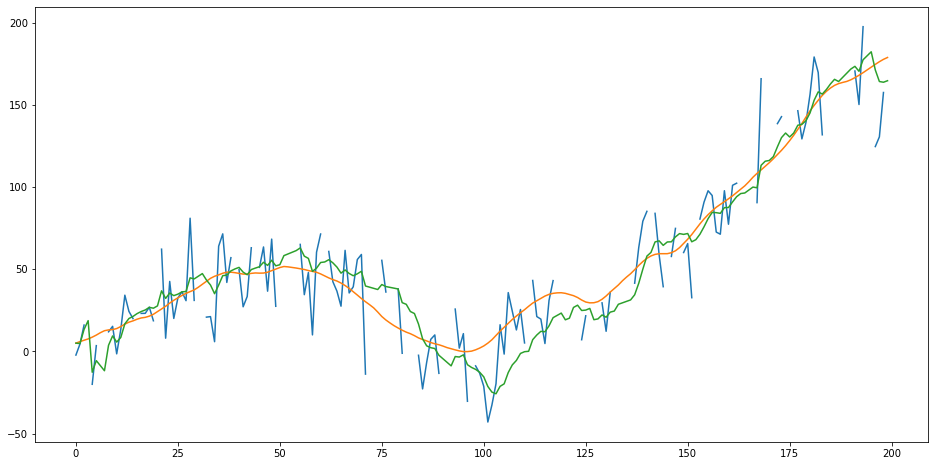

In [20]:
plt.figure(figsize = (16,8))
plt.plot(z)
plt.plot(X[:, 0])
plt.plot(X_filt[:, 0])

In [21]:
P = np.zeros([500, 200, 2, 2])
P_res1 = np.zeros([200, 2, 2])
err1 = np.zeros([500, 197])
err2 = np.zeros([500, 197])
err3 = np.zeros([500, 197])
P0 = np.array([[100, 0], [0, 100]])
m1 = 7
m2 = 1
p = 0.3
for i in range(500):
    v,a = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
    X = np.zeros([200, 2])
    X[0] = X0
    for j in range(1, len(X)):
        X[j] = np.dot(F, X[j - 1]) + np.dot(G, a[j - 1])
    z = np.zeros(200)
    eta = np.random.normal(0, sigmaeta_2 ** 0.5, 200)
    g = np.random.uniform(0, 1, 200)
    for k in range(len(g) - 1):
        if g[k] <= 0.3:
            z[k] = np.nan
        else:
            z[k] = np.dot(H, X[k]) + eta[k]
    X_filt, P[i] = kalman_filt(z, X0, P0, F, Q, R, H)[:2]
    X_extrapol1 = extrapol(X_filt, m1, F)
    X_extrapol2 = extrapol(X_filt, m2, F)
    err1[i] = np.array(X[3:, 0] - X_filt[3:, 0]) ** 2
    err2[i] = np.array(X[3:, 0] - X_extrapol1[3:, 0]) ** 2
    err3[i] = np.array(X[3:, 0] - X_extrapol2[3:, 0]) ** 2
final_err11 = np.zeros(197)
final_err12 = np.zeros(197)
final_err13 = np.zeros(197)
for i in range(197):
    final_err11[i] = (np.mean(err1[:, i])) ** 0.5
    final_err12[i] = (np.mean(err2[:, i])) ** 0.5
    final_err13[i] = (np.mean(err3[:, i])) ** 0.5
for i in range(200):
    P_res1[i] = np.mean(P[:,i])

/var/folders/9y/cbn__xb93h3710lq08dsvk9r0000gn/T/ipykernel_60079/4096187482.py:33: RuntimeWarning: invalid value encountered in reciprocal
  K[i] = (Piin1[i].dot(H.reshape(2, 1))).dot((((H.reshape(1,2)).dot(Piin1[i])).dot(H.reshape(2, 1)) + R) ** (-1)).reshape(1, 2)


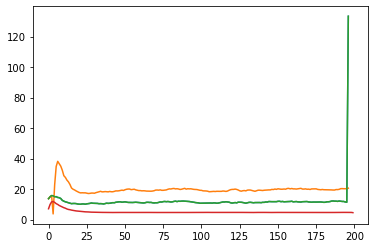

In [22]:
plt.plot(final_err11)
plt.plot(final_err12)
plt.plot(final_err13)
plt.plot(P_res1[:, 0, 0] ** 0.5)

In [23]:
P = np.zeros([500, 200, 2, 2])
P_res2 = np.zeros([200, 2, 2])
err1 = np.zeros([500, 197])
err2 = np.zeros([500, 197])
err3 = np.zeros([500, 197])
P0 = np.array([[100, 0], [0, 100]])
m1 = 7
m2 = 1
p = 0.5
for i in range(500):
    v,a = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
    X = np.zeros([200, 2])
    X[0] = X0
    for j in range(1, len(X)):
        X[j] = np.dot(F, X[j - 1]) + np.dot(G, a[j - 1])
    z = np.zeros(200)
    eta = np.random.normal(0, sigmaeta_2 ** 0.5, 200)
    g = np.random.uniform(0, 1, 200)
    for k in range(len(g) - 1):
        if g[k] <= p:
            z[k] = np.nan
        else:
            z[k] = np.dot(H, X[k]) + eta[k]
    X_filt, P[i] = kalman_filt(z, X0, P0, F, Q, R, H)[:2]
    X_extrapol1 = extrapol(X_filt, m1, F)
    X_extrapol2 = extrapol(X_filt, m2, F)
    err1[i] = np.array(X[3:, 0] - X_filt[3:, 0]) ** 2
    err2[i] = np.array(X[3:, 0] - X_extrapol1[3:, 0]) ** 2
    err3[i] = np.array(X[3:, 0] - X_extrapol2[3:, 0]) ** 2
final_err21 = np.zeros(197)
final_err22 = np.zeros(197)
final_err23 = np.zeros(197)
for i in range(197):
    final_err21[i] = (np.mean(err1[:, i])) ** 0.5
    final_err22[i] = (np.mean(err2[:, i])) ** 0.5
    final_err23[i] = (np.mean(err3[:, i])) ** 0.5
for i in range(200):
    P_res2[i] = np.mean(P[:,i])

/var/folders/9y/cbn__xb93h3710lq08dsvk9r0000gn/T/ipykernel_60079/4096187482.py:33: RuntimeWarning: invalid value encountered in reciprocal
  K[i] = (Piin1[i].dot(H.reshape(2, 1))).dot((((H.reshape(1,2)).dot(Piin1[i])).dot(H.reshape(2, 1)) + R) ** (-1)).reshape(1, 2)


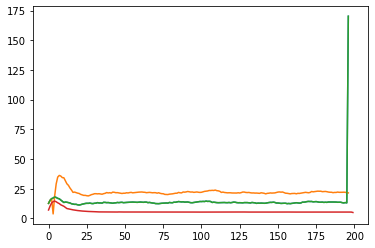

In [24]:
plt.plot(final_err21)
plt.plot(final_err22)
plt.plot(final_err23)
plt.plot(P_res2[:, 0, 0] ** 0.5)

In [25]:
P = np.zeros([500, 200, 2, 2])
P_res3 = np.zeros([200, 2, 2])
err1 = np.zeros([500, 197])
err2 = np.zeros([500, 197])
err3 = np.zeros([500, 197])
P0 = np.array([[100, 0], [0, 100]])
m1 = 7
m2 = 1
p = 0.7
for i in range(500):
    v,a = gnerate_vel_and_ac(0, sigmaa_2 ** 0.5, T, v0, numb)
    X = np.zeros([200, 2])
    X[0] = X0
    for j in range(1, len(X)):
        X[j] = np.dot(F, X[j - 1]) + np.dot(G, a[j - 1])
    z = np.zeros(200)
    eta = np.random.normal(0, sigmaeta_2 ** 0.5, 200)
    g = np.random.uniform(0, 1, 200)
    for k in range(len(g) - 1):
        if g[k] <= p:
            z[k] = np.nan
        else:
            z[k] = np.dot(H, X[k]) + eta[k]
    X_filt, P[i] = kalman_filt(z, X0, P0, F, Q, R, H)[:2]
    X_extrapol1 = extrapol(X_filt, m1, F)
    X_extrapol2 = extrapol(X_filt, m2, F)
    err1[i] = np.array(X[3:, 0] - X_filt[3:, 0]) ** 2
    err2[i] = np.array(X[3:, 0] - X_extrapol1[3:, 0]) ** 2
    err3[i] = np.array(X[3:, 0] - X_extrapol2[3:, 0]) ** 2
final_err31 = np.zeros(197)
final_err32 = np.zeros(197)
final_err33 = np.zeros(197)
for i in range(197):
    final_err31[i] = (np.mean(err1[:, i])) ** 0.5
    final_err32[i] = (np.mean(err2[:, i])) ** 0.5
    final_err33[i] = (np.mean(err3[:, i])) ** 0.5
for i in range(200):
    P_res3[i] = np.mean(P[:,i])

/var/folders/9y/cbn__xb93h3710lq08dsvk9r0000gn/T/ipykernel_60079/4096187482.py:33: RuntimeWarning: invalid value encountered in reciprocal
  K[i] = (Piin1[i].dot(H.reshape(2, 1))).dot((((H.reshape(1,2)).dot(Piin1[i])).dot(H.reshape(2, 1)) + R) ** (-1)).reshape(1, 2)


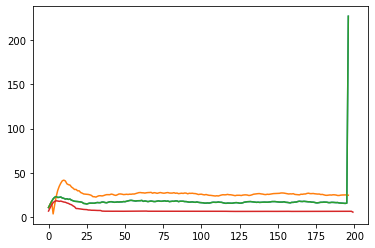

In [26]:
plt.plot(final_err31)
plt.plot(final_err32)
plt.plot(final_err33)
plt.plot(P_res3[:, 0, 0] ** 0.5)

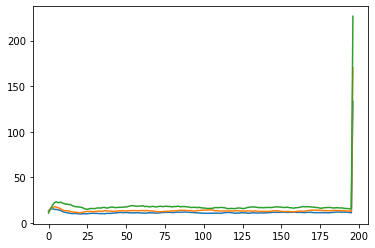

In [27]:
plt.plot(final_err11)
plt.plot(final_err21)
plt.plot(final_err31)

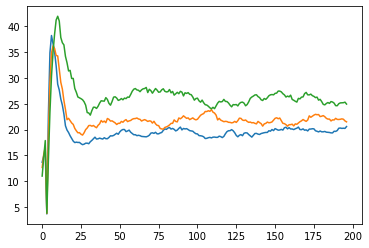

In [28]:
plt.plot(final_err12)
plt.plot(final_err22)
plt.plot(final_err32)

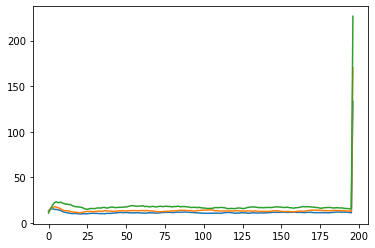

In [29]:
plt.plot(final_err13)
plt.plot(final_err23)
plt.plot(final_err33)

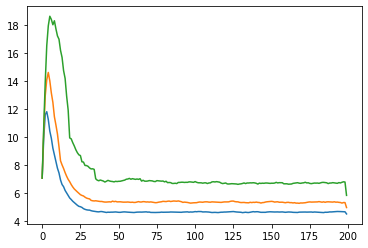

In [30]:
plt.plot(P_res1[:, 0, 0] ** 0.5)
plt.plot(P_res2[:, 0, 0] ** 0.5)
plt.plot(P_res3[:, 0, 0] ** 0.5)